This notebook was created at 23:53 18/10/20

Liquid crystal phase classification using deep learning techniques

First attempt to classify liquid crystal phases using the dataset shared by Josh Heaton.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from skimage.color import rgb2gray
from skimage.transform import resize
from PIL import Image
import tensorflow as tf

Load in the data.

In [3]:
train_directory = "C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)/Liquid_crystals-machine_learning/Images_from_drive/Training"
test_directory = "C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)/Liquid_crystals-machine_learning/Images_from_drive/Validation"
image_size = (200,200)

# Change images to grayscale as colour isnt an important feature at this stage
train_dataset = image_dataset_from_directory(train_directory,
                            labels="inferred",
                            label_mode="categorical",
                            color_mode="grayscale",
                            batch_size=64,
                            image_size=image_size,
                            shuffle=True
                        )
val_dataset = image_dataset_from_directory(test_directory,
                            labels="inferred",
                            label_mode="categorical",
                            color_mode="grayscale",
                            batch_size=64,
                            image_size=image_size,
                            shuffle=True
                        )

Found 1914 files belonging to 5 classes.
Found 313 files belonging to 5 classes.


Let's see if the files imported as expected.

In [4]:
print(train_dataset.element_spec)
print(train_dataset.class_names)
for data, labels in train_dataset:
    print(data.shape)
    print(data.dtype)
    print(labels.shape)
    print(labels.dtype)

(TensorSpec(shape=(None, 200, 200, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))
['Cholesteric', 'Columnar', 'Nematic', 'Smectic', 'Twist_grain_boundary']
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'floa

In [5]:
print(val_dataset.element_spec)
print(val_dataset.class_names)
for data, labels in val_dataset:
    print(data.shape)
    print(data.dtype)
    print(labels.shape)
    print(labels.dtype)

(TensorSpec(shape=(None, 200, 200, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))
['Cholesteric', 'Columnar', 'Nematic', 'Smectic', 'Twist_grain_boundary']
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(57, 200, 200, 1)
<dtype: 'float32'>
(57, 5)
<dtype: 'float32'>


We want to now load in the trained model that was saved at its best point (best meaning highest validation accuracy)

In [6]:
model_filepath = "C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)"
trained_model = tf.keras.models.load_model(model_filepath)

In [7]:
trained_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 1)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 200, 200, 1)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 198, 198, 32)      320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 198, 198, 32)      128       
_________________________________________________________________
activation_3 (Activation)    (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 66, 66, 32)       

Let's get in our validation data but with a seed so we can compare to predictions consistently

In [8]:
trained_model.evaluate(val_dataset, verbose=2)

5/5 - 1s - loss: 0.3728 - accuracy: 0.9233


[0.3727888762950897, 0.9233226776123047]

Now let's get some of the validation images in to see some predictions (this function is from Josh Heaton)

In [24]:
#outputs prediction for image file and associated confidence
def predict_image(filename, model):
    #transform_image(Image.open(filename)).show()
    image = transform_image(Image.open(filename), as_array=True)
    plt.imshow(image, cmap="gray")
    plt.show()
    #expand to 4D tensor so it fits the batch shape
    image = np.expand_dims(image, axis=2)
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image, steps=1, verbose=1)
    pred_class = np.argmax(prediction, axis=1)
    
    print('Predicted phase:')
    
    if pred_class[0] == 0:
        print('cholesteric')
    elif pred_class[0] == 1:
        print('columnar')
    elif pred_class[0] == 2:
        print('nematic')
    elif pred_class[0] == 3:
        print('smectic')
    elif pred_class[0] == 4:
        print('twist_grain_boundary')
        
    print('Confidence level:')
    print(prediction[0][pred_class[0]])
        
    return (pred_class[0], prediction[0][pred_class[0]])

In [25]:
def transform_image(image, as_array=False, size=200, black_and_white=True):
    img = np.array(image)

    height = np.shape(img)[0]
    width = np.shape(img)[1]
    square = (height == width)
    
    #if image is not square, crop excess height/width
    if not square:
        diff = height - width
        crop = int(np.abs(diff) / 2)
        
        if diff > 0:
            img = img[crop:width+crop, :]
        else:
            img = img[:, crop:height+crop]
    
    if black_and_white:
        img = rgb2gray(img)
        
    img = resize(img, (size, size), anti_aliasing=False)
    img *= 255
    img = img.astype(np.uint8)
    
    if as_array:
        return img
    
    return Image.fromarray(img)

In [33]:
val_dir = "C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)/Liquid_crystals-machine_learning/Images_from_drive/Validation"

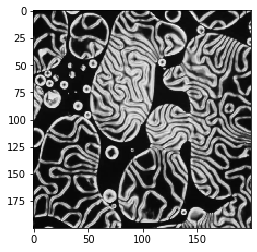

1/1 [==============================] - 0s 1ms/step
Predicted phase:
cholesteric
Confidence level:
1.0


In [34]:
label, confidence = predict_image(val_dir + "/Cholesteric/o00001.png", trained_model)

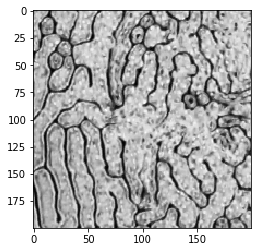

1/1 [==============================] - 0s 1ms/step
Predicted phase:
cholesteric
Confidence level:
0.98415023


In [35]:
label, confidence = predict_image(val_dir + "/Cholesteric/p00481.png", trained_model)

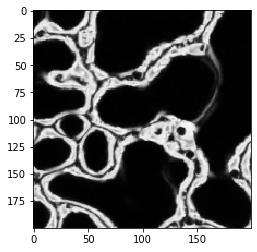

1/1 [==============================] - 0s 2ms/step
Predicted phase:
nematic
Confidence level:
0.9853447


In [36]:
label, confidence = predict_image(val_dir + "/Cholesteric/p00521.png", trained_model)

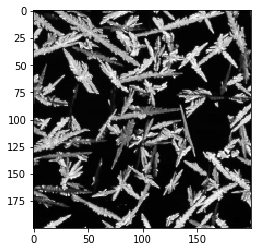

1/1 [==============================] - 0s 2ms/step
Predicted phase:
cholesteric
Confidence level:
0.99699485


In [37]:
label, confidence = predict_image(val_dir + "/Columnar/c00181.png", trained_model)

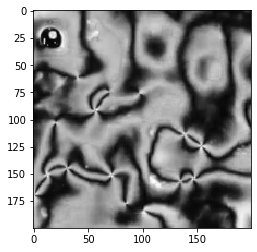

1/1 [==============================] - 0s 1ms/step
Predicted phase:
nematic
Confidence level:
0.99954236


In [38]:
label, confidence = predict_image(val_dir + "/Nematic/h00021.png", trained_model)

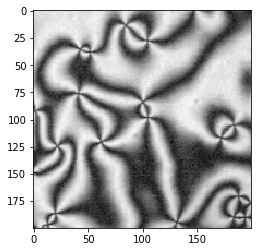

1/1 [==============================] - 0s 998us/step
Predicted phase:
nematic
Confidence level:
0.998965


In [39]:
label, confidence = predict_image(val_dir + "/Nematic/o00331.png", trained_model)

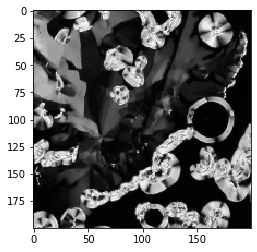

1/1 [==============================] - 0s 211us/step
Predicted phase:
nematic
Confidence level:
0.4350982


In [40]:
label, confidence = predict_image(val_dir + "/Smectic/g00241.png", trained_model)

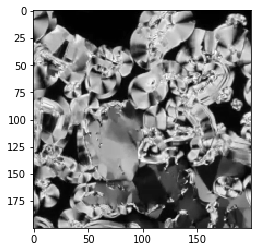

1/1 [==============================] - 0s 1ms/step
Predicted phase:
nematic
Confidence level:
0.7360338


In [41]:
label, confidence = predict_image(val_dir + "/Smectic/h00411.png", trained_model)

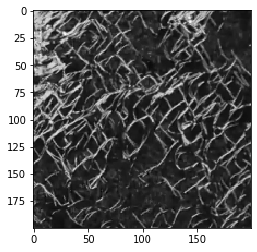

1/1 [==============================] - 0s 999us/step
Predicted phase:
twist_grain_boundary
Confidence level:
0.9949942


In [42]:
label, confidence = predict_image(val_dir + "/Twist_grain_boundary/e00121.png", trained_model)

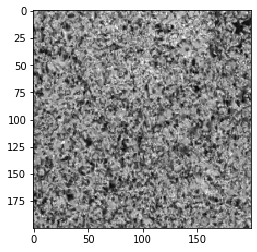

1/1 [==============================] - 0s 342us/step
Predicted phase:
cholesteric
Confidence level:
0.8811735


In [43]:
label, confidence = predict_image(val_dir + "/Twist_grain_boundary/e00271.png", trained_model)

Now let's try with some test images

In [47]:
test_dir = "C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)/Liquid_crystals-machine_learning/Images_from_drive/Test_images_Ingo_book"

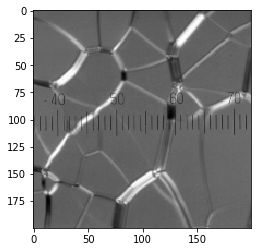

1/1 [==============================] - 0s 679us/step
Predicted phase:
cholesteric
Confidence level:
0.70404696


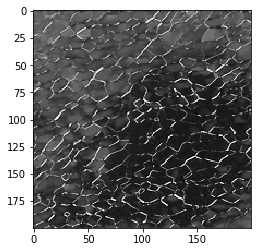

1/1 [==============================] - 0s 1ms/step
Predicted phase:
smectic
Confidence level:
0.960023


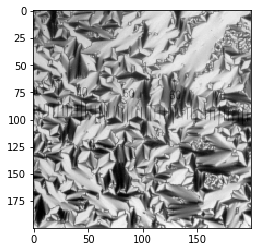

1/1 [==============================] - 0s 2ms/step
Predicted phase:
nematic
Confidence level:
0.85383403


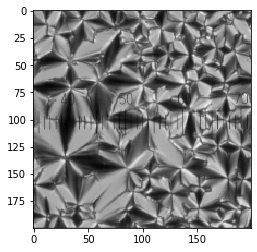

1/1 [==============================] - 0s 967us/step
Predicted phase:
nematic
Confidence level:
0.72762996


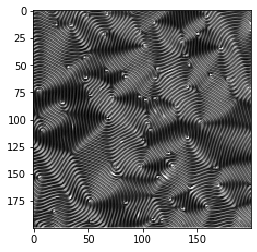

1/1 [==============================] - 0s 987us/step
Predicted phase:
twist_grain_boundary
Confidence level:
0.95064336


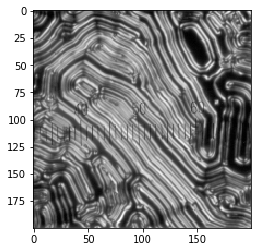

1/1 [==============================] - 0s 0s/step
Predicted phase:
columnar
Confidence level:
0.66226643


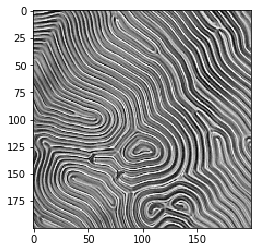

1/1 [==============================] - 0s 1ms/step
Predicted phase:
cholesteric
Confidence level:
1.0


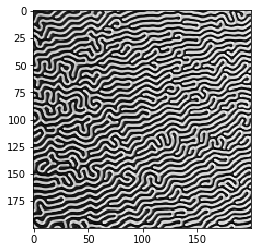

1/1 [==============================] - 0s 1ms/step
Predicted phase:
cholesteric
Confidence level:
1.0


In [48]:
label, confidence = predict_image(test_dir + "/Cholesteric/Cholesteric_Ingo_book.png", trained_model)
label, confidence = predict_image(test_dir + "/Cholesteric/Cholesteric_Ingo_book(1).png", trained_model)
label, confidence = predict_image(test_dir + "/Cholesteric/Cholesteric_Ingo_book(2).png", trained_model)
label, confidence = predict_image(test_dir + "/Cholesteric/Cholesteric_Ingo_book(3).png", trained_model)
label, confidence = predict_image(test_dir + "/Cholesteric/Cholesteric_Ingo_book(4).png", trained_model)
label, confidence = predict_image(test_dir + "/Cholesteric/Cholesteric_Ingo_book(5).png", trained_model)
label, confidence = predict_image(test_dir + "/Cholesteric/Cholesteric_Ingo_book(6).png", trained_model)
label, confidence = predict_image(test_dir + "/Cholesteric/Cholesteric_Ingo_book(7).png", trained_model)

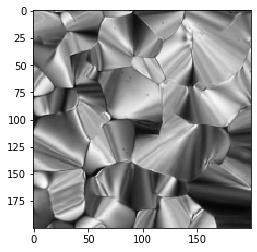

1/1 [==============================] - 0s 1ms/step
Predicted phase:
nematic
Confidence level:
0.9876546


In [50]:
label, confidence = predict_image(test_dir + "/Columnar/Columnar_Ingo_book.png", trained_model)

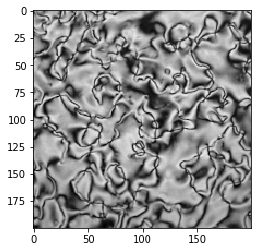

1/1 [==============================] - 0s 0s/step
Predicted phase:
nematic
Confidence level:
0.60242856


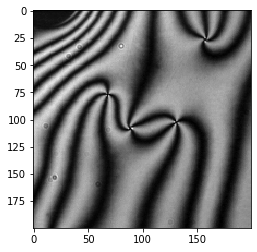

1/1 [==============================] - 0s 2ms/step
Predicted phase:
cholesteric
Confidence level:
0.538126


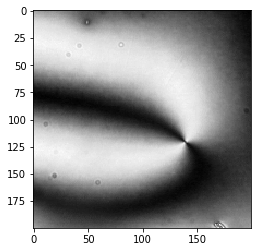

1/1 [==============================] - 0s 1ms/step
Predicted phase:
nematic
Confidence level:
0.96504664


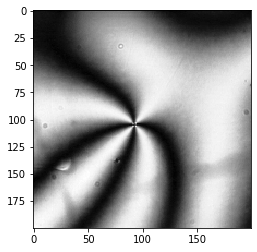

1/1 [==============================] - 0s 1000us/step
Predicted phase:
nematic
Confidence level:
0.992121


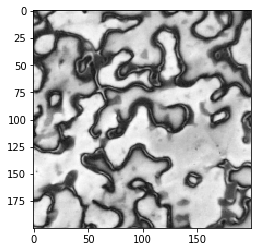

1/1 [==============================] - 0s 2ms/step
Predicted phase:
nematic
Confidence level:
0.99786913


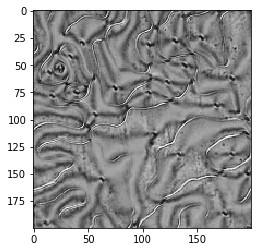

1/1 [==============================] - 0s 2ms/step
Predicted phase:
cholesteric
Confidence level:
0.99979144


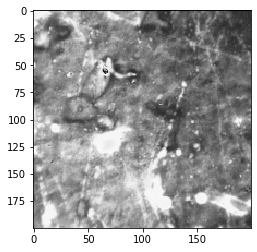

1/1 [==============================] - 0s 1ms/step
Predicted phase:
cholesteric
Confidence level:
0.99103457


In [51]:
label, confidence = predict_image(test_dir + "/Nematic/Nematic_Ingo_book.png", trained_model)
label, confidence = predict_image(test_dir + "/Nematic/Nematic_Ingo_book(1).png", trained_model)
label, confidence = predict_image(test_dir + "/Nematic/Nematic_Ingo_book(2).png", trained_model)
label, confidence = predict_image(test_dir + "/Nematic/Nematic_Ingo_book(3).png", trained_model)
label, confidence = predict_image(test_dir + "/Nematic/Nematic_Ingo_book(4).png", trained_model)
label, confidence = predict_image(test_dir + "/Nematic/Nematic_Ingo_book(5).png", trained_model)
label, confidence = predict_image(test_dir + "/Nematic/Nematic_Ingo_book(6).png", trained_model)

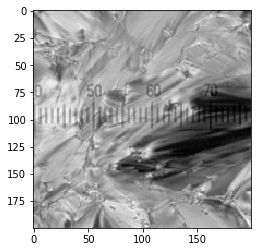

1/1 [==============================] - 0s 995us/step
Predicted phase:
cholesteric
Confidence level:
0.4733992


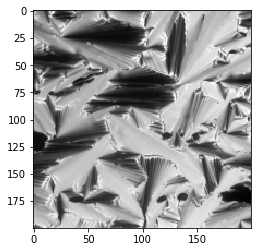

1/1 [==============================] - 0s 1ms/step
Predicted phase:
nematic
Confidence level:
0.98609436


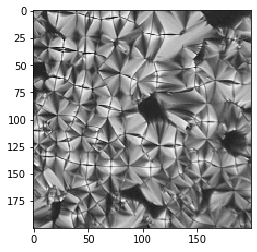

1/1 [==============================] - 0s 2ms/step
Predicted phase:
nematic
Confidence level:
0.6953379


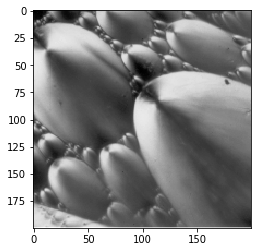

1/1 [==============================] - 0s 1ms/step
Predicted phase:
nematic
Confidence level:
0.99501824


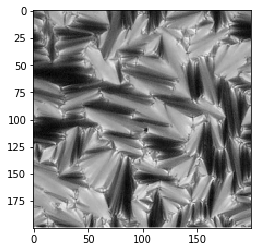

1/1 [==============================] - 0s 997us/step
Predicted phase:
cholesteric
Confidence level:
0.7227947


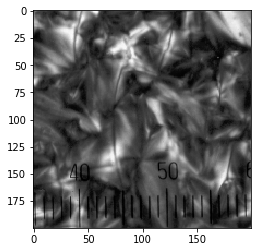

1/1 [==============================] - 0s 1ms/step
Predicted phase:
nematic
Confidence level:
0.9755676


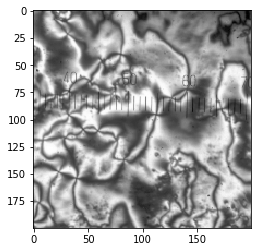

1/1 [==============================] - 0s 2ms/step
Predicted phase:
nematic
Confidence level:
0.9989035


In [52]:
label, confidence = predict_image(test_dir + "/Smectic/SmA_Ingo_book.png", trained_model)
label, confidence = predict_image(test_dir + "/Smectic/SmA_Ingo_book(1).png", trained_model)
label, confidence = predict_image(test_dir + "/Smectic/SmA_Ingo_book(2).png", trained_model)
label, confidence = predict_image(test_dir + "/Smectic/SmA_Ingo_book(3).png", trained_model)
label, confidence = predict_image(test_dir + "/Smectic/SmA_Ingo_book(4).png", trained_model)
label, confidence = predict_image(test_dir + "/Smectic/SmC_Ingo_book.png", trained_model)
label, confidence = predict_image(test_dir + "/Smectic/SmC_Ingo_book(1).png", trained_model)

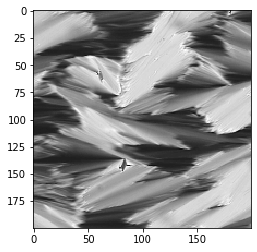

1/1 [==============================] - 0s 998us/step
Predicted phase:
nematic
Confidence level:
0.9875646


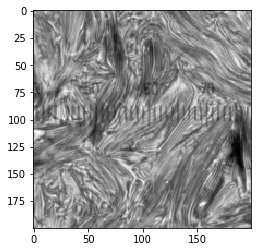

1/1 [==============================] - 0s 1ms/step
Predicted phase:
nematic
Confidence level:
0.46742818


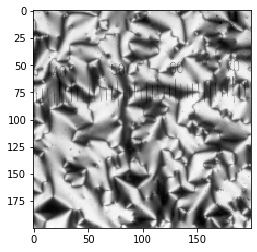

1/1 [==============================] - 0s 1ms/step
Predicted phase:
nematic
Confidence level:
0.99992526


In [53]:
label, confidence = predict_image(test_dir + "/Twist_grain_boundary/TGB_Ingo_book.png", trained_model)
label, confidence = predict_image(test_dir + "/Twist_grain_boundary/TGB_Ingo_book(1).png", trained_model)
label, confidence = predict_image(test_dir + "/Twist_grain_boundary/TGB_Ingo_book(2).png", trained_model)

Despite working well on the validation set (which was completely unseen), the performance on the test images here are mixed. It's possible that the model doesn't generalise well to more difficult cases of LC textures.